### Use the code in this notebook to retrive the machine learning model from Azure Machine Learning Workspace
### Forecast
### Visualise the results

In [4]:
'''Don't change the code in here'''

# import library 
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# import machine learning library 
from azureml.core import Experiment, Run, Workspace
import azureml.core
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.0.57


### <font color='red'>Fill in details in the cell below as instructed</font>

In [5]:
# connect to Azure Machine Learning Workspace
subscription_id = ''
resource_group  = ''
workspace_name  = ''

In [6]:
'''Don't change the code in here'''

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    ws.write_config()
    print('Library configuration succeeded')
except:
    print('Workspace not found')

Library configuration succeeded


In [7]:
'''Don't change the code in here'''

# write a function that finds the best model from ws and downloads it
def find_best_model(run_name, ws):
    # import library
    from azureml.core.experiment import Experiment
    from tqdm import tqdm
    import pandas as pd

    # write a functiont that finds the experiment with the matching name
    def find_expr():
        expr = None
        for e in Experiment.list(ws):
            if run_name in e.name:
                expr = e                  
        return expr   
    
    # write a function for getting the model filename
    def get_model_filename():
        modelfilename = None
        for f in bestrun.get_file_names():
            if(f[-4:] == '.pkl'):
                modelfilename = f
        return modelfilename
    
    runs = {}
    run_metrics = {}
    runsorder = {}
    i=0
    expr = find_expr()
    
    # if found experiment with matching name, get the lastest run
    if expr != None:
        r = expr.get_runs().__next__()
        print(r,'\n')
        metrics = r.get_metrics()
        for s in tqdm(r.get_children()):
            metrics = s.get_metrics()
            if 'normalized_root_mean_squared_error' in metrics.keys():
                i=i+1
                runs[s.id] = s
                run_metrics[s.id] = metrics

        best_run_id = min(run_metrics, key = lambda k : run_metrics[k]['root_mean_squared_error'])
        bestrun = runs[best_run_id]
        modelfilename = get_model_filename()
        if modelfilename != None:
            # Download the model
            modelname = 'm_'+ run_name
            modelload = bestrun.register_model(model_name=modelname, model_path=modelfilename)
            model = modelload.download(exist_ok = True) 
            print('model download complete!\n') 
            
            model_metrics = run_metrics[best_run_id]
            print('\nmodel metrics:\n')
            print('mean_absolute_error: ', model_metrics['mean_absolute_error'])
            print('mean_absolute_percentage_error: ', model_metrics['mean_absolute_percentage_error'])
            print('normalized_root_mean_squared_error: ', model_metrics['normalized_root_mean_squared_error'])
            print('\n')
            return(model, model_metrics)
        else:
            print('get_model_filename() returned None!')
            return None
    
    # if found experiment with matching name, get the lastest run
    else:
        print('no experiment of matching name: '+run_name+ '  is found!')
        return None
    

In [8]:
'''Don't change the code in here'''

# write a function that loads the model and makes forecasts
def load_best_model(model, future_date):
    # Load the model
    import pickle
    import azureml
    import azureml.train.automl
    
    model = pickle.load(open(model, 'rb'))
    
    from datetime import datetime
    from dateutil import parser

    result = model.forecast(forecast_destination = np.datetime64(parser.parse(future_date))) # example format: "27 May 2021"
    resultdf = result[1]

    dfresfinal = pd.DataFrame(list(resultdf.iloc[:,0].index.values))
    dfresfinal.columns = ['date', 'description']
    dfresfinal['quantity'] = pd.DataFrame(resultdf['_automl_target_col'].values)
    
    dfResults = dfresfinal
    dfResults.drop(columns = ['description'], inplace=True)
    # Sort the results in case we are not already sorted    
    dfResults.sort_values(by=['date'], inplace=True)
    
    return dfResults
 

# write a function that process test data, used in comparison and plotting later
def process_test_data(modelname):
    df = pd.read_csv('export_concat_df.csv')
    
    # write a function that lists all the items in concat_df
    def list_items():
        items = df.description.unique().tolist()
        return items
     
    # retrive index number from model number
    try:
        items = list_items()
        if modelname[-6]!='-':
            index = int(modelname[-6:-4])
        else:
            index = int(modelname[-5:-4])
        description = modelname[-3:]
        
        # filter concat_df by matching index and description
        if items[index-1][0:3] == description:
            filter_df = df.loc[df['description'] == items[index-1]]
            filter_df.drop(columns = ['description'], inplace = True)
            filter_df.reset_index(inplace = True)
            filter_df.drop(columns = ['index'], inplace = True)
            filter_df['date'] = pd.to_datetime(filter_df['date'])
            return(filter_df)
        
        else:
            print('mismatching model to data, please check that export_concat_df is also the dataframe used for model training')
            return(None)
    
    except ValueError:
        print('model name is incorrect!')
        return(None)
        
        
# write a function that generates a fan chart for given data
def plot_fan_chart(filter_df, df_results, mean_abs_error):
    x = df_results['date'].tolist()
    y = df_results['quantity'].tolist()
    scale = [a for a in range(0,len(x))]    
    mean_abs_error_list = [mean_abs_error*i*0.25 for i in scale]
    #fig, ax = plt.subplots()
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    y_above = [y[i]+mean_abs_error_list[i] for i in range(0,len(y))]
    y_below = [y[i]-mean_abs_error_list[i] for i in range(0,len(y))]
    
    ax.fill_between(x, y_above, y_below, color='pink', label='25% of mean_absolute_error') # Plot interval
    ax.plot(x, y, color='red', label='Predict') # Plot the original signal
    ax.plot(filter_df['date'],filter_df['quantity'], label='True')
    plt.legend(loc=2)
    plt.ylim(bottom = 0)
    plt.show()
       
        
# write a function that loads the true data and compares
def compare_true_predict(modelname, model, future_date, mean_abs_error):
    
    # turn off data conversion warning
    import warnings
    from sklearn.exceptions import DataConversionWarning
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    
    filter_df = process_test_data(modelname)
    df_results = load_best_model(model, future_date)
    print('Predictions from '+ modelname + ' :\n', df_results)
    
    plot_fan_chart(filter_df, df_results, mean_abs_error)   
    

### Run the function below to check the list of trained models

In [9]:
'''Don't change the code in here'''

trained_models = []
for e in Experiment.list(ws):
    trained_models.append(str(e.name))
trained_models.sort()
print(trained_models)

['testrun1-1-5X1', 'testrun1-10-TUB', 'testrun1-11-eas', 'testrun1-2-Buf', 'testrun1-3-Buf', 'testrun1-4-Buf', 'testrun1-5-CON', 'testrun1-6-Dis', 'testrun1-7-Lys', 'testrun1-8-MIC', 'testrun1-9-MIC', 'testrun2-1-5X1', 'testrun2-10-TUB', 'testrun2-11-eas', 'testrun2-2-Buf', 'testrun2-3-Buf', 'testrun2-4-Buf', 'testrun2-5-CON', 'testrun2-6-Dis', 'testrun2-7-Lys', 'testrun2-8-MIC', 'testrun2-9-MIC', 'testrun3-1-5X1', 'testrun3-10-TUB', 'testrun3-11-eas', 'testrun3-2-Buf', 'testrun3-3-Buf', 'testrun3-4-Buf', 'testrun3-5-CON', 'testrun3-6-Dis', 'testrun3-7-Lys', 'testrun3-8-MIC', 'testrun3-9-MIC']


### <font color='red'>Change the</font> <font color='orange'>run_name</font>  to select a different model
### Select model name from the list above
### <font color='red'>Change the</font> <font color='orange'> future_date </font>to forecast

In [12]:
# use this funtion to produce predictions
# and to get a plot for the prediction

run_name = 'testrun2-4-Buf' # change the run name here
future_date = '30 September 2019' # example format '30 September 2019' 

### Run the function below to make prediction and plot

Run(Experiment: testrun2-4-Buf,
Id: AutoML_f6002fb7-ba94-4810-9aa1-35147b873ed1,
Type: automl,
Status: Completed) 



25it [00:06,  3.75it/s]


model download complete!


model metrics:

mean_absolute_error:  1.8800000000000001
mean_absolute_percentage_error:  31.66666666666667
normalized_root_mean_squared_error:  0.31333333333333335


Predictions from testrun2-4-Buf :
                   date  quantity
0  2018-12-28 03:30:00      0.00
1  2019-01-16 03:00:00      0.50
2  2019-02-04 02:30:00      2.40
3  2019-02-23 02:00:00      1.80
4  2019-03-14 01:30:00      3.00
5  2019-04-02 01:00:00      1.60
6  2019-04-21 00:30:00      1.20
7  2019-05-10 00:00:00      1.20
8  2019-05-28 23:30:00      1.20
9  2019-06-16 23:00:00      0.00
10 2019-07-05 22:30:00      0.60
11 2019-07-24 22:00:00      0.00
12 2019-08-12 21:30:00      0.00
13 2019-08-31 21:00:00      0.60
14 2019-09-19 20:30:00      0.00


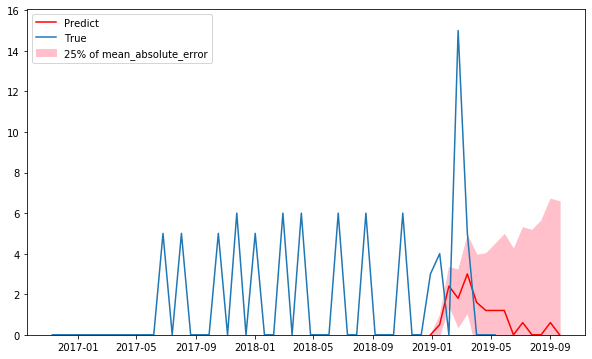

In [13]:
'''Don't change the code in here'''
best_model, model_metrics = find_best_model(run_name, ws) 
compare_true_predict(run_name , best_model, future_date, mean_abs_error = model_metrics['mean_absolute_error'])

In [66]:
# This for loop runs all models in Azure workspace

# for i in trained_models:
#     run_name = i
#     best_model, model_metrics = find_best_model(run_name, ws) 
#     compare_true_predict(run_name , best_model, future_date, mean_abs_error = model_metrics['mean_absolute_error'])